**Reconnaissance paroles à l'aide de KeysPoints**

Qu'est-ce que les KeyPoints ?  

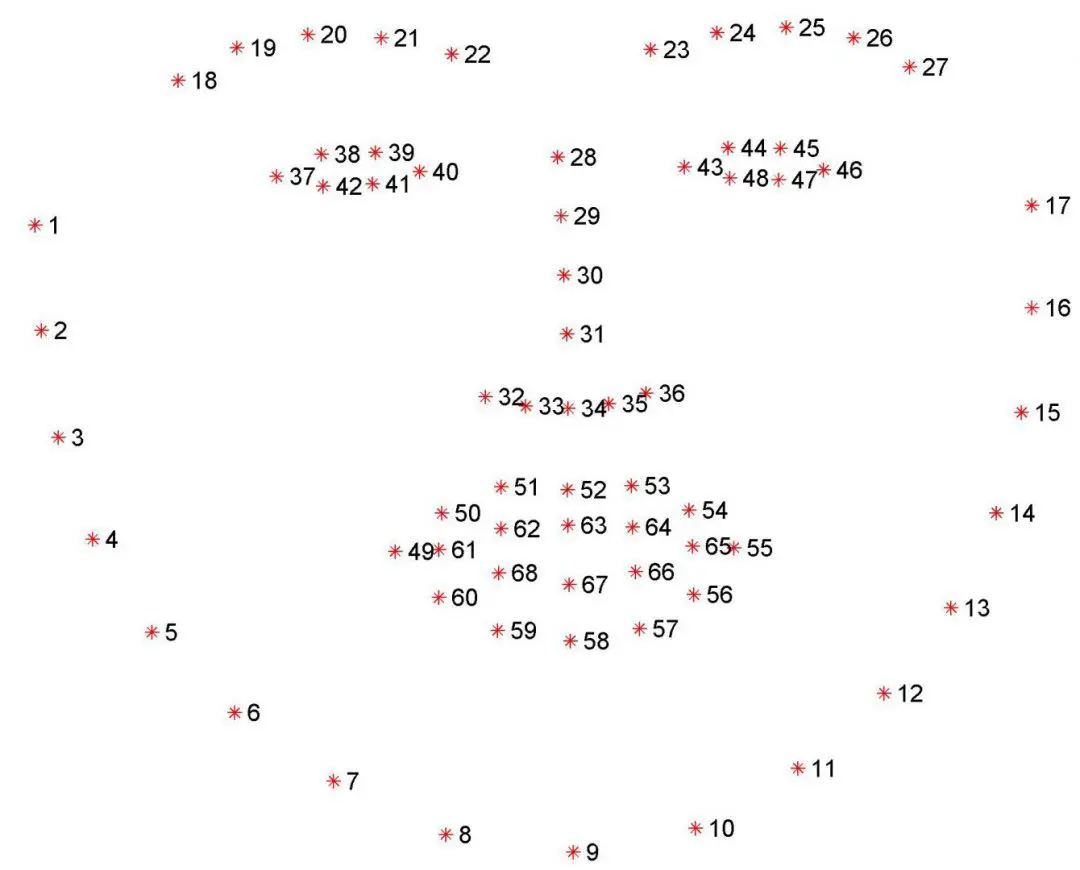

Les KeyPoints que nous observons appartiennent en réalité à **dlib**. Il faudra également télécharger un prédicteur.

In [10]:
import cv2
import dlib
import math
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger le détecteur de visages et le prédicteur de points clés de Dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(r"..\shape_predictor_68_face_landmarks.dat")

points_cles_interessants = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


Tout d'abord, nous aurons besoin d'une fonction pour obtenir les points clés des lèvres.

Afin de faciliter l'entraînement du réseau, nous ferons pivoter les images pour que les lèvres soient toujours droites.

In [11]:
def lips_points_labios(imagen):
    lips_points = []

    # Detect faces
    faces = detector(imagen)

    # For each detected face, predict keypoints
    for face in faces:
        landmarks = predictor(imagen, face)

        lips_points = []

        for n in points_cles_interessants:  # Lip points indices in the 68-point model
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            lips_points.append((x, y))
            
        break

    return np.array(lips_points)

def angle_bouche(commissure_gauche, commissure_droite):
    global angle_lissé
    
    angle_lissé = None
    facteur_lissage = 0.2  # Ajustez cette valeur (0.1-0.5) pour des résultats plus lissés ou plus réactifs

    dx = commissure_droite[0] - commissure_gauche[0]
    dy = commissure_droite[1] - commissure_gauche[1]

    # Calculer l'angle actuel
    angle_actuel = math.degrees(math.atan2(dy, dx))

    # Si aucun angle précédent, initialiser avec l'angle actuel
    if angle_lissé is None:
        angle_lissé = angle_actuel
    else:
        # Lisser l'angle
        angle_lissé = (1 - facteur_lissage) * angle_lissé + facteur_lissage * angle_actuel
        
    return angle_lissé


def rotation_image_angle_0(image, angle, point1, point2):
    centre_point_D1 = (point1[0] + point2[0]) / 2
    centre_point_D2 = (point1[1] + point2[1]) / 2
    centre = (centre_point_D1, centre_point_D2)
    matrice_rotation = cv2.getRotationMatrix2D(centre, angle, 1.0)
    image_rotée = cv2.warpAffine(image, matrice_rotation, (image.shape[1], image.shape[0]))
    return image_rotée


Étape 1 - Centrage des points sur le centre de l'ensemble :

Tout d'abord, la fonction calcule le **centroïde** (moyenne) de tous les points clés. Le centroïde est le "centre de masse" des points. Il est calculé en prenant la moyenne des coordonnées **x** et **y** de tous les points.
Ensuite, tous les points sont déplacés vers le centroïde. Cela se fait en soustrayant le centroïde de chaque point, ce qui signifie que tous les points clés seront réajustés autour du centre, au lieu d'être dispersés dans tout l'espace.

Étape 2 - Mise à l'échelle des points :

Ensuite, on calcule la **distance maximale** entre les points et le centroïde. Cela permet de s'assurer que les points se trouvent dans une plage standard.
La distance de chaque point au centroïde est calculée en utilisant la formule de la distance euclidienne, qui est la longueur de la ligne droite entre un point et le centroïde.
La fonction prend la plus grande distance parmi tous les points et l'utilise comme facteur d'échelle. Ensuite, tous les points sont mis à l'échelle en divisant leurs distances par cette distance maximale. Cela garantit que les points se trouvent dans une plage standard, ici entre **-1 et 1**.

In [12]:
def normalize_keypoints(points):
    """
    Normaliser un ensemble de points clés dans un cadre en les centrant sur le centroïde
    et en les mettant à l'échelle selon la distance maximale au centroïde.

    Arguments :
    - points (numpy array) : Tableau de taille (K, 2), où :
        K : Nombre de points clés dans un cadre.
        2 : Coordonnées (x, y).

    Renvoie :
    - points_normalisés (numpy array) : Points clés normalisés dans la plage [-1, 1].
    """
    points = np.array(points)  # S'assurer qu'il s'agit d'un tableau NumPy

    # 1. Centrer sur le centroïde
    centroïde = points.mean(axis=0)  # Centroïde du cadre
    points_centres = points - centroïde

    # 2. Mise à l'échelle selon la distance maximale au centroïde
    distance_maximale = np.linalg.norm(points_centres, axis=1).max()  # Distance maximale au centroïde
    if distance_maximale == 0:
        distance_maximale = 1e-8  # Éviter la division par zéro
    
    points_mis_à_l_échelle = points_centres / distance_maximale  # Normaliser dans la plage [-1, 1]
    
    return points_mis_à_l_échelle


In [13]:
def dessiner_levres(lips_points, image):
    for tupla in lips_points:
        cv2.circle(image, (tupla[0], tupla[1]), 1, (0, 255, 0), -1)
        
    cv2.imshow("Image rotée", image)
    return image

Nous prenons d abord un frame de la caméra, récupérons les points clés et faisons pivoter l image. Ensuite, nous prenons cette image pivotée, recalculons les points clés et dessinons les lèvres. Après cela, nous devrons normaliser les points clés et les utiliser.  

Pour sortir vidéo: Q

In [14]:
def temps_reel():
    # Video capture from a file
    cap = cv2.VideoCapture(0)

    while True:
        # Capture the video frame
        ret, frame = cap.read()
        if not ret:
            continue

        # Processing lip points
        lips_points_antes_rotacion = lips_points_labios(frame)
        
        if lips_points_antes_rotacion.size != 0 and len(lips_points_antes_rotacion) == len(points_cles_interessants):
            print(lips_points_antes_rotacion)

            indice_comisura_iz = points_cles_interessants.index(48)
            indice_comisura_der = points_cles_interessants.index(54)
            
            # Angle calculation and image rotation
            angulo = angle_bouche(lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
            imagen_rotada = rotation_image_angle_0(frame, angulo, lips_points_antes_rotacion[indice_comisura_iz], lips_points_antes_rotacion[indice_comisura_der])
            
            # Normalize lip points
            lips_points = lips_points_labios(imagen_rotada)
            
            print(normalize_keypoints(lips_points))
            
            dessiner_levres(lips_points, imagen_rotada)
        else:
            cv2.imshow("Image rotée", frame)

        # Exit the loop if the 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

temps_reel()


[[261 433]
 [269 430]
 [277 428]
 [283 429]
 [289 426]
 [297 424]
 [306 425]
 [299 433]
 [293 438]
 [286 440]
 [280 441]
 [271 440]
 [265 433]
 [278 432]
 [284 432]
 [290 429]
 [302 426]
 [291 431]
 [285 434]
 [279 434]]
[[-0.99470721 -0.10274998]
 [-0.64492006 -0.19019676]
 [-0.25140952 -0.23392016]
 [ 0.01093085 -0.14647337]
 [ 0.27327121 -0.23392016]
 [ 0.62305837 -0.19019676]
 [ 0.97284552 -0.14647337]
 [ 0.62305837  0.15959039]
 [ 0.27327121  0.29076057]
 [ 0.01093085  0.33448396]
 [-0.29513291  0.33448396]
 [-0.64492006  0.24703718]
 [-0.86353703 -0.10274998]
 [-0.25140952 -0.01530319]
 [ 0.01093085 -0.01530319]
 [ 0.27327121 -0.05902658]
 [ 0.84167534 -0.10274998]
 [ 0.27327121  0.02842021]
 [ 0.01093085  0.0721436 ]
 [-0.25140952  0.0721436 ]]
[[263 426]
 [271 422]
 [279 420]
 [285 421]
 [291 418]
 [299 418]
 [309 420]
 [301 427]
 [294 431]
 [287 433]
 [281 434]
 [272 433]
 [267 426]
 [279 425]
 [286 424]
 [292 423]
 [305 420]
 [292 425]
 [286 427]
 [280 427]]
[[-0.95913734 -0.

Graphes utilisé pour analyser les points clés.

In [16]:
def creer_graphique(historique):
    plt.plot(historique, marker='o', linestyle='-', color='b', label='Changements entre frames')

    # Personnalisation du graphique
    plt.xlabel("Indice de la Frame")
    plt.ylabel("Changement")
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Ligne à y=0
    plt.grid(alpha=0.3)
    #plt.legend()

    # Afficher le graphique
    plt.show()
    
def graphique_histogramme(historique):
    # Créer un histogramme
    plt.figure(figsize=(10, 5))
    plt.hist(historique, bins=len(np.unique(historique)), color='blue', alpha=0.7, edgecolor='black')
    
    # Étiquettes et titre de l'histogramme
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    
    # Afficher l'histogramme
    plt.show()

Comme on a pu le voir à la caméra, les points des lèvres sont reconnus avec une certaine erreur, ils ont tendance à trembler, ce qui peut contribuer à ce que le réseau soit moins performant. Nous allons également essayer de rechercher s'il y a deux frames très similaires et les combiner en une seule pour concentrer l'information.

In [17]:
def traiter_video(chemin_video):
    historique_différences = []
    historique_points = []
    
    historique_différences_par_dimension = []
    
    for dimension in points_cles_interessants:
        historique_différences_par_dimension.append([])

    frames_totaux = 0   
    frames_sans_omettre = 0
    
    points_lèvres_précédents = np.empty(0)

    # Capture de vidéo depuis un fichier
    cap = cv2.VideoCapture(chemin_video)
    
    # Temps réel
    #cap = cv2.VideoCapture(0)

    while True:
        # Capturer le frame de la vidéo
        ret, frame = cap.read()
        if not ret:
            break

        # Traitement des points des lèvres
        points_lèvres_avant_rotation = lips_points_labios(frame)
        if len(points_lèvres_avant_rotation) != len(points_cles_interessants):
            break

        indice_commissure_gauche = points_cles_interessants.index(48)
        indice_commissure_droite = points_cles_interessants.index(54)
        
        # Calcul de l'angle et rotation de l'image
        angle = angle_bouche(points_lèvres_avant_rotation[indice_commissure_gauche], points_lèvres_avant_rotation[indice_commissure_droite])
        image_rotée = rotation_image_angle_0(frame, angle, points_lèvres_avant_rotation[indice_commissure_gauche], points_lèvres_avant_rotation[indice_commissure_droite])
        
        # Normaliser les points des lèvres
        points_lèvres = lips_points_labios(image_rotée)
        
        points_lèvres_normalisés = normalize_keypoints(points_lèvres)
        
        frames_totaux += 1
        
        if points_lèvres_précédents.size != 0:
            # Calculer la distance moyenne entre les points actuels et précédents
            distances = np.linalg.norm(points_lèvres - points_lèvres_précédents, axis=1)
            distance_moyenne = np.mean(distances)
            historique_différences.append(distance_moyenne)
            dessiner_levres(points_lèvres, image_rotée)
            
        # Stocker les points historiques
        historique_points.append(points_lèvres_normalisés.sum(axis=1))
        points_lèvres_précédents = points_lèvres

        # Quitter la boucle si la touche 'q' est pressée
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Libérer la vidéo et fermer les fenêtres
    cap.release()
    cv2.destroyAllWindows()
    creer_graphique(historique_différences)
    graphique_histogramme(historique_différences)
    

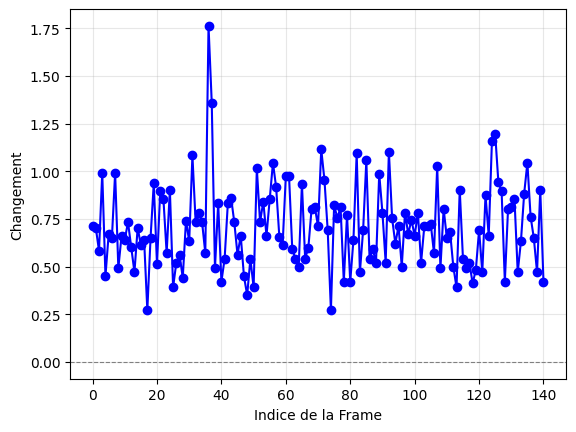

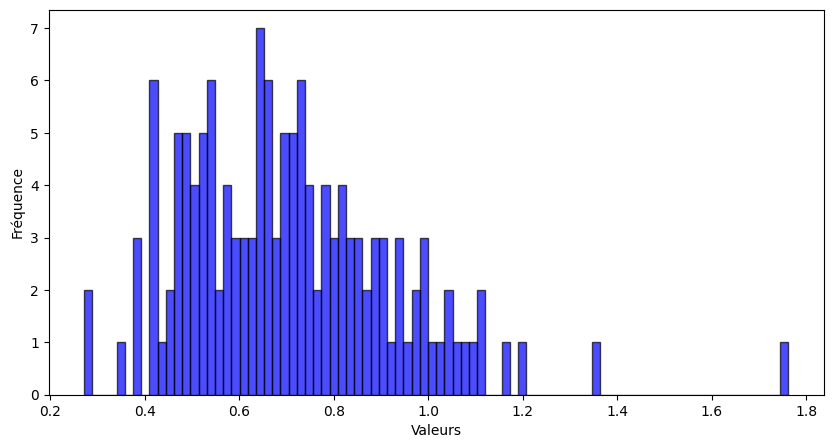

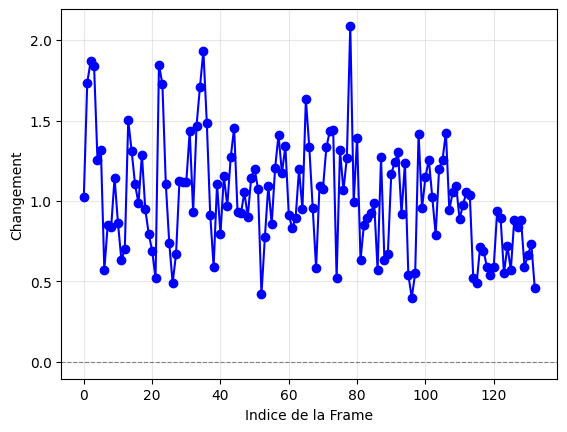

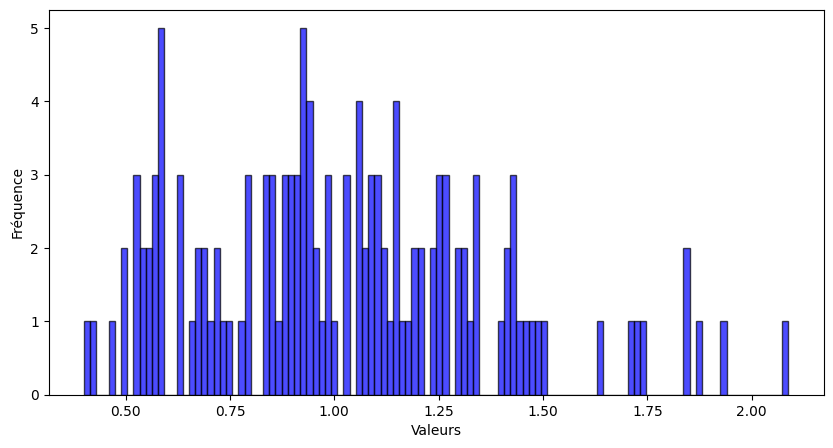

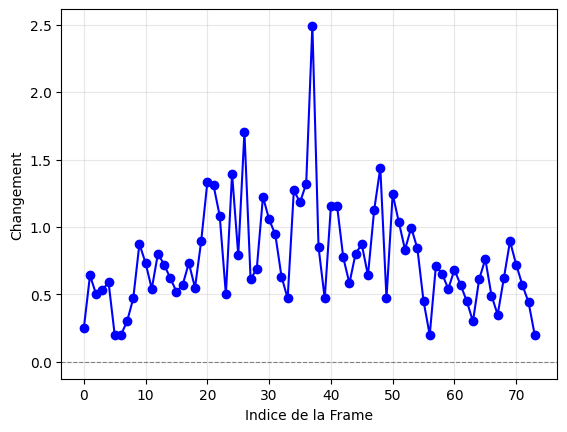

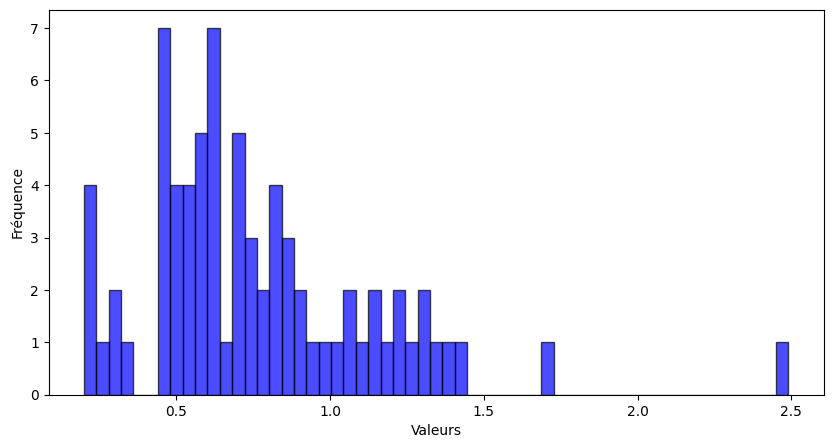

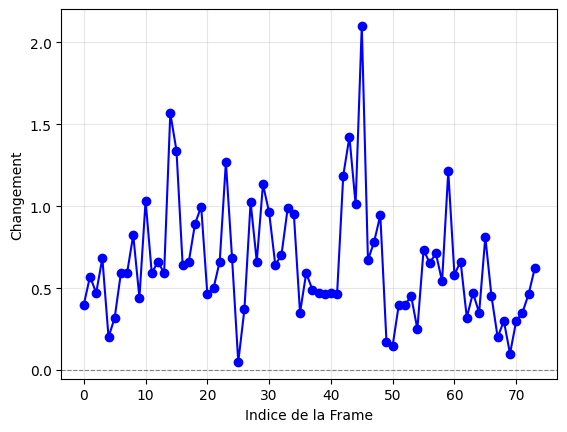

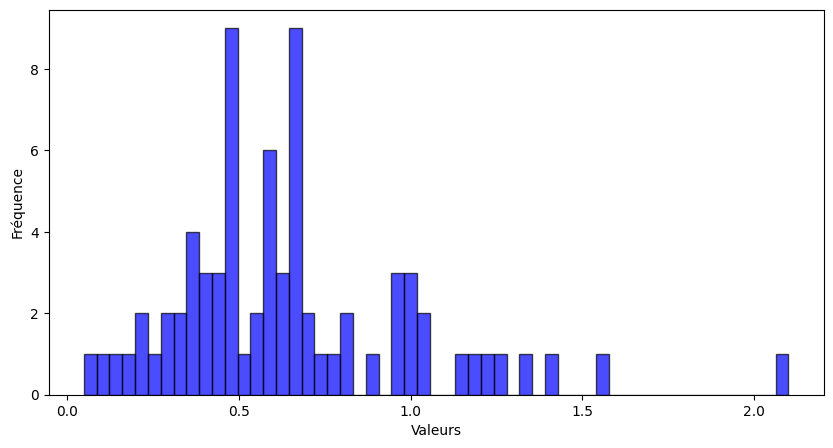

In [8]:
#####################################################################################################################
# Ejecucion expetimental, estudio de la varianza de frame y treshold
    
# Ejemplo de uso
chemin_video_hola_lent = r"..\data\analyse\lento_buenos_dias.mp4"
chemin_video_hola_rapide = r"..\data\analyse\rapido_buenos_dias.mp4"
chemin_video_calme_long = r"..\data\analyse\quieto_largo.mp4"
chemin_video_calme_rapide = r"..\data\analyse\quieto_rapido.mp4"

traiter_video(chemin_video_calme_rapide)
traiter_video(chemin_video_hola_rapide)

path_data_set_1 = r"..\data\analyse\s1\vid\bbaf2n.mpg"
path_data_set_2 = r"..\data\analyse\s1\vid\bbaf3s.mpg"

traiter_video(path_data_set_1)
traiter_video(path_data_set_2)

In [18]:
def procesar_video_sans_rotacion(ruta_video):
    historial_diferencias = []
    historial_puntos = []
    
    historial_diferencias_por_dimension = []
    
    for dimension in points_cles_interessants:
        historial_diferencias_por_dimension.append([])
    
    frames_totales = 0   
    frames_sin_omitir = 0
    
    lips_points_anterior = np.empty(0)

    # Captura de video desde un archivo
    cap = cv2.VideoCapture(ruta_video)
    
    # tiempo real
    #cap = cv2.VideoCapture(0)

    while True:
        # Capturar el frame del video
        ret, frame = cap.read()
        if not ret:
            break

        # Procesamiento de los puntos de los labios
        lips_points_antes_rotacion = lips_points_labios(frame)
        if len(lips_points_antes_rotacion) != len(points_cles_interessants):
            break

        
        lips_points_normalizados = normalize_keypoints(lips_points_antes_rotacion)
        
        frames_totales += 1
        
        if lips_points_anterior.size != 0:
            # Calcular la distancia promedio entre los puntos actuales y los anteriores
            distances = np.linalg.norm(lips_points_antes_rotacion - lips_points_anterior, axis=1)
            mean_distance = np.mean(distances)
            historial_diferencias.append(mean_distance)
            dessiner_levres(lips_points_antes_rotacion,frame)
            
        # Almacenar puntos históricos
        historial_puntos.append(lips_points_normalizados.sum(axis=1))
        lips_points_anterior = lips_points_antes_rotacion

        # Romper el bucle si se presiona la tecla 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Liberar el video y cerrar las ventanas
    cap.release()
    cv2.destroyAllWindows()
    creer_graphique(historial_diferencias)
    graphique_histogramme(historial_diferencias)

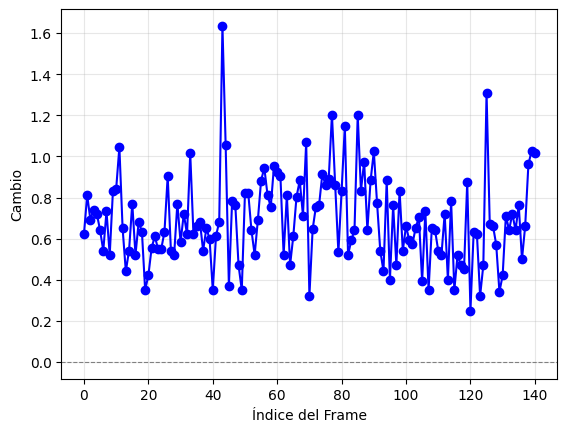

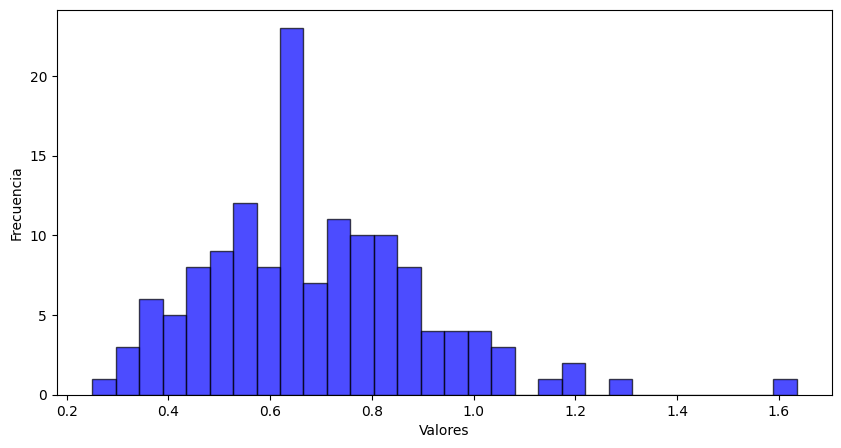

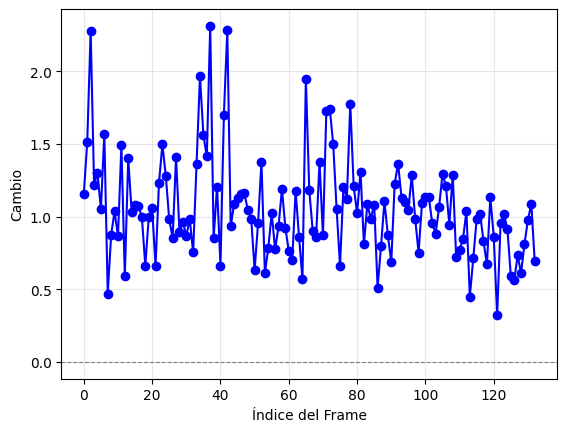

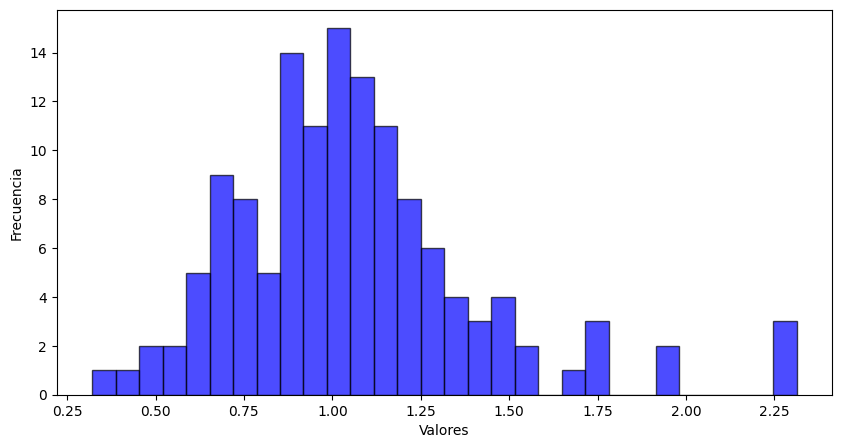

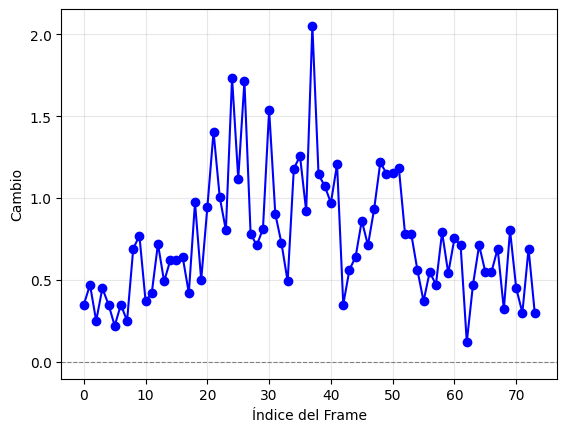

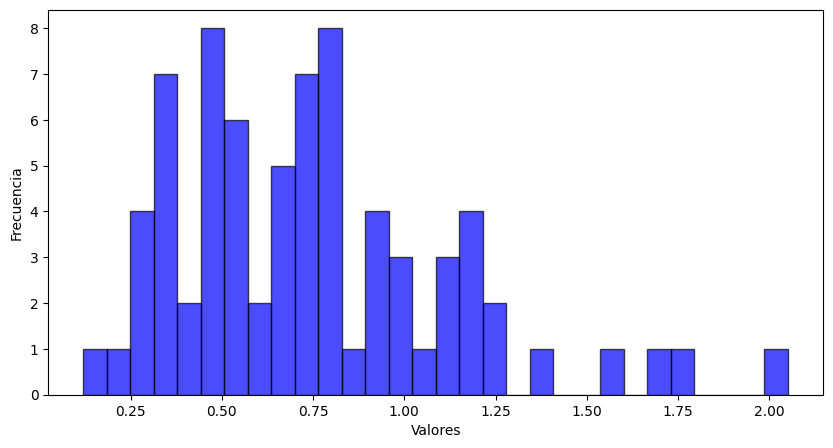

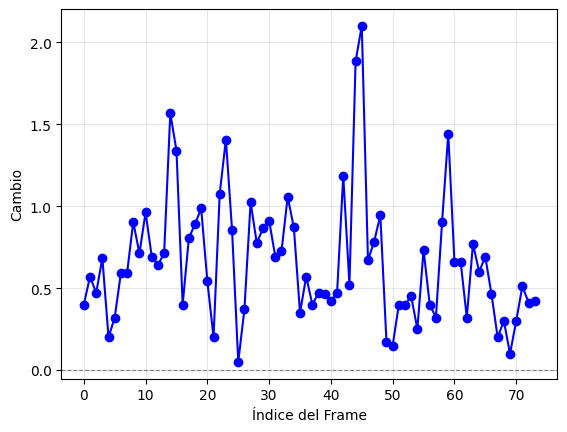

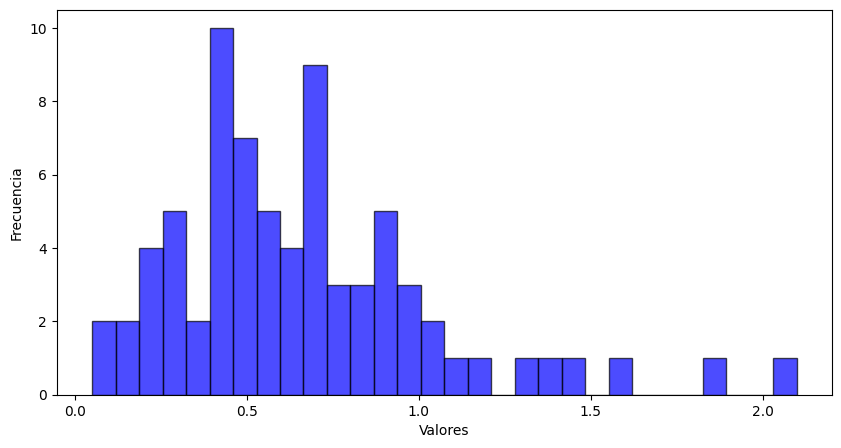

In [78]:
#####################################################################################################################
# Ejecucion expetimental, estudio de la varianza de frame y treshold
    
# Ejemplo de uso
ruta_video_hola_lento = r"..\data\analyse\lento_buenos_dias.mp4"
ruta_video_hola_rapido = r"..\data\analyse\rapido_buenos_dias.mp4"
ruta_video_quieto_largo = r"..\data\analyse\quieto_largo.mp4"
ruta_video_quieto_rapido = r"..\data\analyse\quieto_rapido.mp4"

procesar_video_sans_rotacion(ruta_video_quieto_rapido)
procesar_video_sans_rotacion(ruta_video_hola_rapido)

ruta_data_set_1 = r"..\data\analyse\bbaf2n.mpg"
ruta_data_set_2 = r"..\data\analyse\bbaf3s.mpg"

procesar_video_sans_rotacion(ruta_data_set_1)
procesar_video_sans_rotacion(ruta_data_set_2)

In [19]:
def lire(fichier):
    # Leer y mostrar contenido
    with open(fichier, "r") as f:
        contenue = f.read()

    # Mostrar el contenido
    print(contenue)

Finalement, au lieu de créer plusieurs vidéos et de générer un dataset pour 2 ou 3 mots, j'ai décidé d'utiliser un dataset existant appelé GRID.

Ce dataset contient des vidéos et des fichiers d'alignement, qui indiquent de quel frame à quel frame un mot est prononcé.  

Le problème est que le fichier d'alignement est basé sur le son, donc lorsque le mot commence à être entendu, l'information sur la position des lèvres avant de dire le mot est perdue.

In [20]:
archivo = r"../data/analyse/s1/alignements/bbaf2n.align"
lire(archivo)

0 23750 sil
23750 29500 bin
29500 34000 blue
34000 35500 at
35500 41000 f
41000 47250 two
47250 53000 now
53000 74500 sil



Avec cette fonction, les frames associés à chaque mot sont extraits, de sorte qu'un mot aura x tableaux de 20 éléments (points clés).

In [21]:
import os
def split_video_to_labels_and_keypoints(video_path, intervals_file):
    # Lire le fichier d'intervalles
    with open(intervals_file, 'r') as file:
        lines = file.readlines()

    # Charger la vidéo
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Erreur : Impossible d'ouvrir la vidéo {video_path}")
        raise Exception("La vidéo n'a pas pu être ouverte correctement")

    # Liste pour stocker les données structurées
    labels = []
    labels_key_points = []
    
    ancien_label = None

    for line in lines:
        start_frame, end_frame, label = line.strip().split()
        start_frame, end_frame = math.ceil(int(start_frame) / 1000), math.ceil(int(end_frame) / 1000)

        # Définir la position initiale de la frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        #print(f"Traitement des frames pour l'étiquette '{label}' de la frame {start_frame} à {end_frame}...")
        
        if ancien_label != label:
            
            # Changement sans reconnaissance de keypoints
            if ancien_label != None and np.any(np.array(key_points) == None):
                labels.pop()
            elif ancien_label != None:
                labels_key_points.append(np.array(key_points))
                
            labels.append(label)
            key_points = []
            ancien_label = label
            
        # Parcourir les frames de l'intervalle
        for frame_num in range(start_frame, end_frame):
            ret, frame = cap.read()
            if not ret:
                return (None, None)
            
            kp_avant_rotation = lips_points_labios(frame)
            
            if not(np.any(np.array(kp_avant_rotation) == None) or kp_avant_rotation.size == 0):
                indice_commissure_gauche = points_cles_interessants.index(48)
                indice_commissure_droite = points_cles_interessants.index(54)
                
                # Calcul de l'angle et rotation de l'image
                angle = angle_bouche(kp_avant_rotation[indice_commissure_gauche], kp_avant_rotation[indice_commissure_droite])
                image_rotatee = rotation_image_angle_0(frame, angle, kp_avant_rotation[indice_commissure_gauche], kp_avant_rotation[indice_commissure_droite])
                    
                kp = lips_points_labios(image_rotatee)

                if not(np.any(np.array(kp) == None) or kp.size == 0):
                    key_points.append(np.array(normalize_keypoints(kp)))

            
    # Libérer les ressources d'OpenCV
    cap.release()
    #print("Traitement terminé.")

    # Convertir la liste en np.array structuré
    return (np.array(labels), labels_key_points)


Avec cette autre fonction, toutes les données collectées sont sauvegardées et stockées dans un fichier txt.

Comme ce fichier pèse 21 Mo, j'ai pu l'ajouter sur GitHub.

In [22]:

FIN_BLOC = "################################################################################"
FIN_ELEMENT = "########"

def sauvegarder_entrainement(labels, arrays, nom_fichier):
    """
    Sauvegarde les étiquettes et les tableaux multidimensionnels dans un fichier texte,
    en les ajoutant à la fin du fichier s'il existe déjà.
    
    Args:
    labels (list): Liste des étiquettes.
    arrays (list): Liste des tableaux NumPy multidimensionnels.
    nom_fichier (str): Nom du fichier où les données seront sauvegardées.
    """
    try:
        with open(nom_fichier, 'a') as f:  # Mode ajout ('a')
            for label, arr in zip(labels, arrays):
                f.write(f"{label}\n")  # Écrire l'étiquette
                for elm in arr:
                    np.savetxt(f, elm, delimiter=' ', fmt='%.6g')  # Sauvegarder le tableau
                    f.write(f"{FIN_ELEMENT}\n")
                f.write(f"\n{FIN_BLOC}\n")  # Séparateur entre blocs
    except Exception as e:
        raise Exception(f"Erreur lors de la sauvegarde des données : {e}")
        
        
def lire_entrainement(nom_fichier):
    """
    Lit les étiquettes et les tableaux multidimensionnels à partir d'un fichier texte,
    en considérant les séparateurs FIN_ELEMENT et FIN_BLOC.
    
    Args:
    nom_fichier (str): Nom du fichier d'où les données seront lues.
    
    Returns:
    tuple:
        - labels (list): Liste des étiquettes.
        - arrays (list): Liste des tableaux NumPy multidimensionnels.
    """
    labels = []
    arrays = []
    try:
        with open(nom_fichier, 'r') as f:
            while True:
                label = f.readline().strip()  # Lire l'étiquette
                if not label:  # Si plus d'étiquettes, terminer
                    break
                arr = []
                temp = []  # Pour stocker le sous-tableau courant
                while True:
                    line = f.readline().strip()
                    if line == FIN_BLOC:  # Fin du bloc
                        if temp:  # Sauvegarder le dernier sous-tableau s'il existe
                            arr.append(np.array(temp))
                        break
                    elif line == FIN_ELEMENT:  # Fin d'un sous-tableau
                        if temp:  # Sauvegarder le sous-tableau s'il existe
                            arr.append(np.array(temp))
                        temp = []  # Réinitialiser le sous-tableau temporaire
                    elif line:  # Éviter les lignes vides et traiter le contenu
                        temp.append(list(map(float, line.split())))  # Convertir en flottants
                if arr:
                    labels.append(label)
                    arrays.append(arr)  
    except Exception as e:
        print(f"Erreur lors de la lecture des données : {e}")
    
    return np.array(labels), arrays


In [23]:
def affiner_base_de_donnees(fichier_affine):
    try:
        os.remove(fichier_affine)
    except:
        pass
    # Spécifie le dossier à lister
    chemin_dossier_ali = r'..\data\analyse\s1\alignements\\'
    chemin_dossier_vid = r'..\data\analyse\s1\vid\\'

    # Liste les fichiers et dossiers dans le dossier
    alis = os.listdir(chemin_dossier_ali)
    vids = os.listdir(chemin_dossier_vid)
    
    alis = [chemin_dossier_ali + file for file in alis]
    vids = [chemin_dossier_vid + file for file in vids]
    
    compteur = 0
    nombre_fichiers = len(alis)
    
    for i in range(len(alis)):
        compteur += 1
        print(f"Traitement de {compteur} sur {nombre_fichiers}")
        labels, arrays = split_video_to_labels_and_keypoints(vids[i], alis[i])
        if labels is None:
            print("Erreur lors du chargement de la frame, passage à la vidéo suivante")
        else:
            sauvegarder_entrainement(labels, arrays, fichier_affine)
            print("Vidéo bien sauvegardée")
        
    print("FINNN")


In [24]:
archivo_refinado = r"..\data\analyse\s1_petit.txt"
affiner_base_de_donnees(archivo_refinado)

Traitement de 1 sur 2
Vidéo bien sauvegardée
Traitement de 2 sur 2
Vidéo bien sauvegardée
FINNN


sil
24


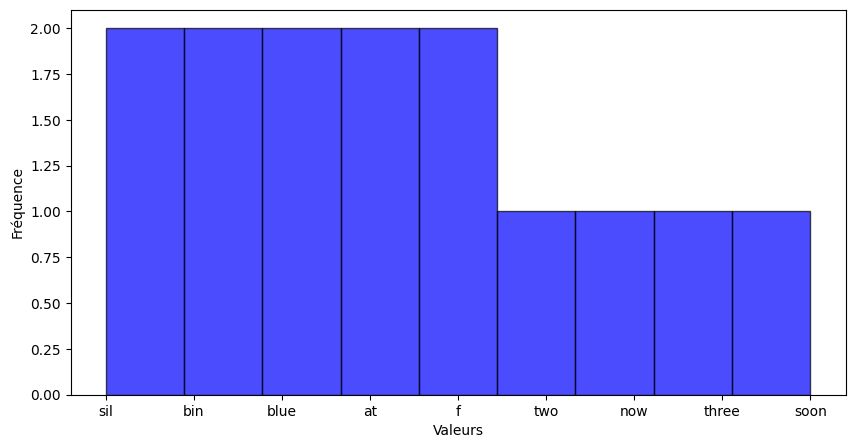

In [24]:

archivo_refinado = r"..\data\analyse\s1_petit.txt"
labels, arrays = lire_entrainement(archivo_refinado)
print(labels[0])
print(len(arrays[0]))
graphique_histogramme(labels)

In [25]:
def calculer_limite_longueur(sequences):
    """
    Calcule la limite de longueur pour des séquences basée sur la moyenne + 2 écarts-types.
    
    Args:
        sequences (list of list): Liste de séquences, où chaque séquence est une liste de points clés ou de frames.
    
    Returns:
        int: Limite recommandée pour la longueur des séquences.
    """
    longueurs = [len(seq) for seq in sequences]
    moyenne = np.mean(longueurs)
    ecart_type = np.std(longueurs)
    limite = int(moyenne + 2 * ecart_type)
    return limite

Étiquette : five, Moyenne de longueur : 6.959595959595959
Étiquette : seven, Moyenne de longueur : 8.030303030303031
Étiquette : white, Moyenne de longueur : 5.871485943775101
Étiquette : o, Moyenne de longueur : 3.6052631578947367
Étiquette : zero, Moyenne de longueur : 8.717171717171718
Étiquette : j, Moyenne de longueur : 4.55
Étiquette : p, Moyenne de longueur : 4.7
Étiquette : two, Moyenne de longueur : 6.17
Étiquette : in, Moyenne de longueur : 2.6175298804780875
Étiquette : one, Moyenne de longueur : 5.3
Étiquette : k, Moyenne de longueur : 4.825
Étiquette : m, Moyenne de longueur : 4.25
Étiquette : lay, Moyenne de longueur : 9.850202429149798
Étiquette : f, Moyenne de longueur : 4.175
Étiquette : h, Moyenne de longueur : 4.6
Étiquette : eight, Moyenne de longueur : 5.15
Étiquette : red, Moyenne de longueur : 4.8582995951417
Étiquette : soon, Moyenne de longueur : 9.518072289156626
Étiquette : r, Moyenne de longueur : 4.95
Étiquette : l, Moyenne de longueur : 3.825
Étiquette : e

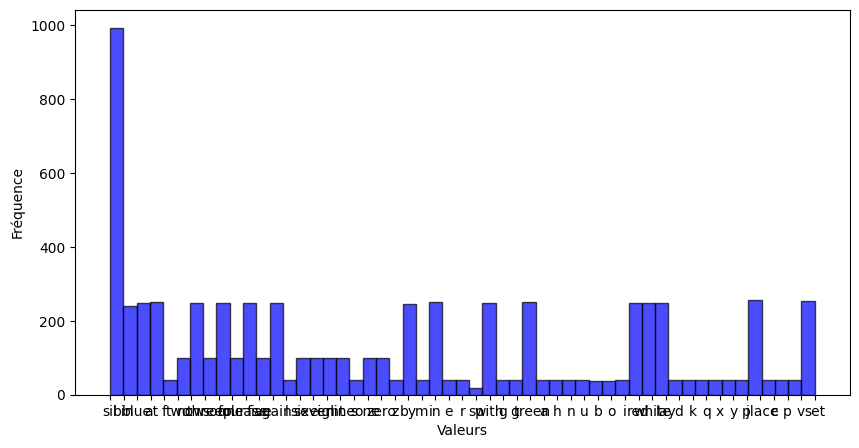

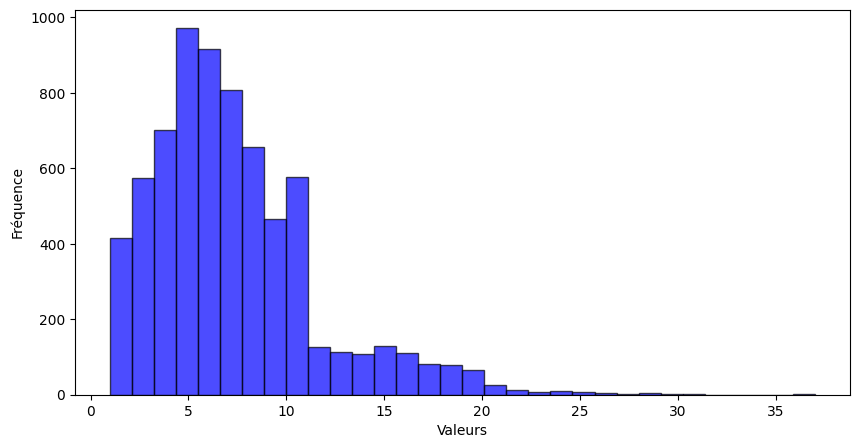

Nous couperons toutes les données dont la taille dépasse 15


In [27]:
from collections import Counter
from statistics import mean

# Supposons que les étiquettes et les tableaux ont déjà été lus
fichier_affine = r"..\data\processed\s1.txt"
labels, arrays = lire_entrainement(fichier_affine)

# Calcul des longueurs des tableaux
longueurs = [len(element) for element in arrays]

# Calcul de la moyenne des longueurs par étiquette
longueurs_par_label = {}
for label in set(labels):
    longueurs_label = [longueurs[i] for i in range(len(labels)) if labels[i] == label]
    longueurs_par_label[label] = mean(longueurs_label)

# Affiche le résultat
for label, moyenne in longueurs_par_label.items():
    print(f"Étiquette : {label}, Moyenne de longueur : {moyenne}")

# Optionnel : tracer des histogrammes si pertinent
graphique_histogramme(labels)
graphique_histogramme(longueurs)
print(f"Nous couperons toutes les données dont la taille dépasse {calculer_limite_longueur(arrays)}")



In [26]:
def appliquer_padding(sequences, longueur_cible):
    """
    Applique un padding à toutes les séquences afin qu'elles aient la même longueur.
    
    Args:
        sequences (list of list): Liste de séquences, où chaque séquence est une liste de points clés ou de frames.
        longueur_cible (int): Longueur fixe souhaitée pour toutes les séquences.
    
    Returns:
        np.array: Matrice contenant toutes les séquences remplies avec du padding (zéros).
    """
    sequences_padded = []
    for sequence in sequences:
        sequence = np.array(sequence)
        # Si la séquence est plus courte que la longueur cible, ajoute des zéros à la fin
        if len(sequence) < longueur_cible:
            padding = np.zeros(shape=(longueur_cible - len(sequence), 20, 2)) 
            #print(sequence.shape)
            
            sequence_padded = np.concatenate((sequence, padding))
            
        else:
            sequence_padded = sequence
        sequences_padded.append(sequence_padded)
    
    return np.array(sequences_padded)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_5              │ (None, 15, 18, 32)     │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 15, 9, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 15, 288)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 128)        │       213,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,509 (1.04 MB)

 Trainable params: 271,125 (1.03 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.1055 - loss: 3.5972 - val_accuracy: 0.1851 - val_loss: 3.3103
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.1770 - loss: 3.0526 - val_accuracy: 0.2818 - val_loss: 2.6487
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2266 - loss: 2.7837 - val_accuracy: 0.2917 - val_loss: 2.5215
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2386 - loss: 2.6697 - val_accuracy: 0.3145 - val_loss: 2.4235
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2836 - loss: 2.5452 - val_accuracy: 0.2544 - val_loss: 2.7077
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2963 - loss: 2.4671 - val_accuracy: 0.3503 - val_loss: 2.3738
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3192 - loss: 2.3966 - val_accuracy: 0.2589 - val_loss: 2.8596
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3544 - loss: 2.2888 - val_acc

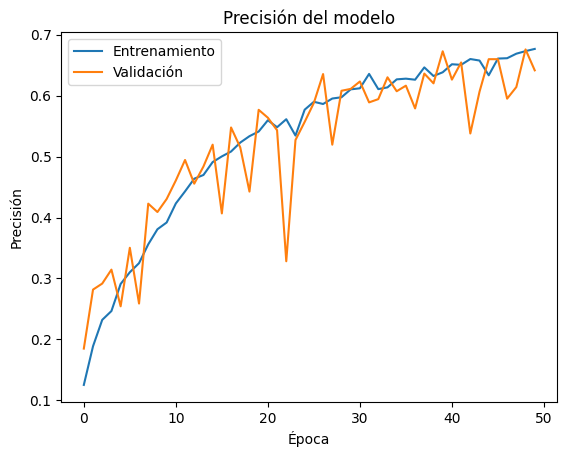

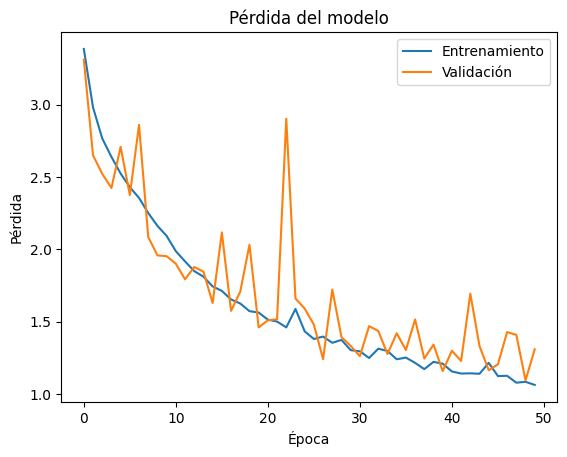

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6499 - loss: 1.2473


Pérdida: 1.3092819452285767, Precisión: 0.6412795186042786


In [32]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


archivo_refinado = r"..\data\processed\s1.txt"
labels, arrays = lire_entrainement(archivo_refinado)

# Define los hiperparámetros
input_dim = len(points_cles_interessants)  # Número de keypoints por frame (ejemplo)
longitud = calculer_limite_longueur(arrays)
longitudes = [len(seq) for seq in arrays]

classes = np.unique(labels).size 
arrays_threshold = []
labels_threshold = []

for i in range(len(arrays)):
    if len(arrays[i])<=longitud:
        arrays_threshold.append(arrays[i])
        labels_threshold.append(labels[i])
            
num_classes = np.unique(labels).size      # Número de palabras a reconocer

time_steps = longitud  # Número de frames en cada secuencia

# Crear un mapeo de etiquetas únicas a enteros
unique_labels = np.unique(labels_threshold)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}

# Convertir las etiquetas usando el mapeo
labels_threshold_int = [label_to_int[label] for label in labels_threshold]

y_train = to_categorical(labels_threshold_int, num_classes=num_classes)

X_padding = appliquer_padding(arrays_threshold,longitud)

# Dividir en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_padding, y_train, test_size=0.2, random_state=42)

model = Sequential([
    # TimeDistributed para procesar las relaciones espaciales (keypoints)
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(15, 20, 2)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),  # Reduce las dimensiones a (15, features)
    
    # LSTM para capturar patrones temporales
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64),
    Dropout(0.3),
    BatchNormalization(),
    
    # Capa densa intermedia
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    # Capa de salida para clasificación
    Dense(num_classes, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()

# Entrenar el modelo
epochs = 50
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Graficar resultados
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Evaluar el modelo
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Pérdida: {loss}, Precisión: {accuracy}")

# Guardar el modelo
model.save('modelo_clasificador_lstm_rotacion.h5')

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


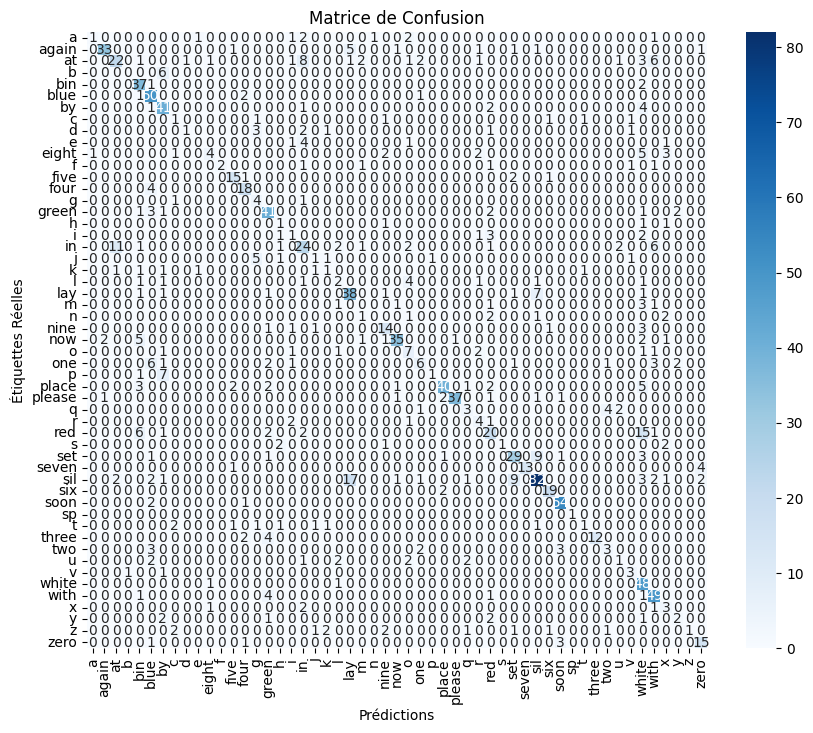

Étiquette: a, Précision: 0.50
Étiquette: again, Précision: 0.92
Étiquette: at, Précision: 0.61
Étiquette: b, Précision: 0.00
Étiquette: bin, Précision: 0.62
Étiquette: blue, Précision: 0.66
Étiquette: by, Précision: 0.63
Étiquette: c, Précision: 0.14
Étiquette: d, Précision: 0.50
Étiquette: e, Précision: 0.00
Étiquette: eight, Précision: 0.57
Étiquette: f, Précision: 1.00
Étiquette: five, Précision: 0.75
Étiquette: four, Précision: 0.72
Étiquette: g, Précision: 0.29
Étiquette: green, Précision: 0.69
Étiquette: h, Précision: 0.14
Étiquette: i, Précision: 0.11
Étiquette: in, Précision: 0.49
Étiquette: j, Précision: 0.20
Étiquette: k, Précision: 0.17
Étiquette: l, Précision: 0.22
Étiquette: lay, Précision: 0.62
Étiquette: m, Précision: 0.00
Étiquette: n, Précision: 0.00
Étiquette: nine, Précision: 0.61
Étiquette: now, Précision: 0.88
Étiquette: o, Précision: 0.33
Étiquette: one, Précision: 0.46
Étiquette: p, Précision: 0.50
Étiquette: place, Précision: 0.89
Étiquette: please, Précision: 0

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prédire les étiquettes sur l'ensemble de validation
y_pred = model.predict(X_val)

# Convertir les one-hot encodings en entiers
y_val_int = np.argmax(y_val, axis=1)
y_pred_int = np.argmax(y_pred, axis=1)

# Générer la matrice de confusion
conf_matrix = confusion_matrix(y_val_int, y_pred_int)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Prédictions')
plt.ylabel('Étiquettes Réelles')
plt.title('Matrice de Confusion')
plt.show()

# Générer un rapport de classification
class_report = classification_report(y_val_int, y_pred_int, target_names=unique_labels, output_dict=True)

# Afficher la précision par étiquette
for label, metrics in class_report.items():
    if isinstance(metrics, dict):  # Considérer uniquement les étiquettes valides
        print(f"Étiquette: {label}, Précision: {metrics['precision']:.2f}")


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.0607 - loss: 0.5746 - val_accuracy: 0.0054 - val_loss: 0.3442
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0672 - loss: 0.2443 - val_accuracy: 0.0000e+00 - val_loss: 0.2193
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.0823 - loss: 0.2187 - val_accuracy: 0.0486 - val_loss: 0.2346
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.0856 - loss: 0.2034 - val_accuracy: 0.0095 - val_loss: 0.2096
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1032 - loss: 0.1846 - val_accuracy: 0.1676 - val_loss: 0.1819
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1004 - loss: 0.1739 - val_accuracy: 0.1324 - val_loss: 0.2158
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.0931 - loss: 0.1683 - val_accuracy: 0.1257 - val_loss: 0.1826
Epoch 8/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1163 - loss: 0.1649 - val_accuracy: 0.2932

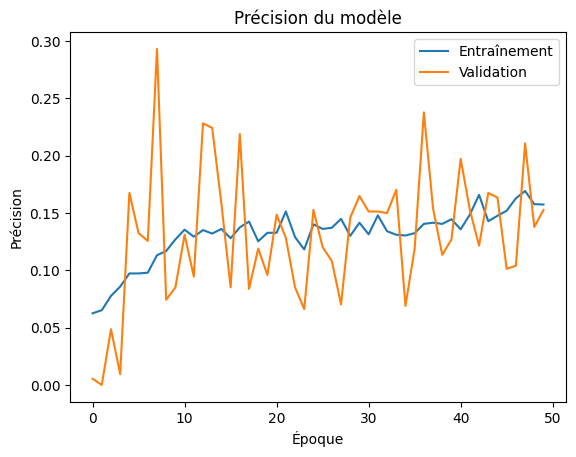

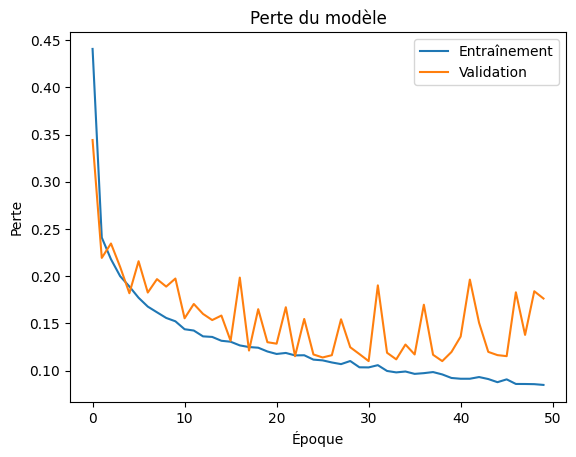

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1561 - loss: 0.1873


Perte : 0.1762835681438446, Précision : 0.1527027040719986


In [29]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def creer_fenetres_combinees(arrays, labels, taille_fenetre, glissement):

    fenetres = []
    etiquettes = []
    for seq, label_seq in zip(arrays, labels):
        for i in range(0, len(seq) - taille_fenetre + 1, glissement):
            fenetre = seq[i:i + taille_fenetre]
            etiquettes_fenetre = label_seq[i:i + taille_fenetre]
            
            # Combiner les étiquettes uniques présentes dans la fenêtre
            etiquettes_uniques = sorted(set(etiquettes_fenetre))  # Triées pour la cohérence
            etiquettes.append(etiquettes_uniques)
            fenetres.append(fenetre)
    
    return np.array(fenetres), etiquettes

def etiquettes_a_one_hot(etiquettes, etiquettes_uniques_totales):

    etiquettes_one_hot = []
    etiquette_a_index = {etiquette: idx for idx, etiquette in enumerate(etiquettes_uniques_totales)}
    nombre_classes = len(etiquettes_uniques_totales)
    
    for liste_etiquettes in etiquettes:
        vecteur = np.zeros(nombre_classes)
        for etiquette in liste_etiquettes:
            idx = etiquette_a_index[etiquette]
            vecteur[idx] = 1
        etiquettes_one_hot.append(vecteur)
    
    return np.array(etiquettes_one_hot)

if __name__ == "__main__":
    
    # charger_les_donnees()
    # Charger et préparer les données
    fichier_traite = r"..\data\processed\s1.txt"
    labels, arrays = lire_entrainement(fichier_traite)
    
    # Définir les paramètres de la fenêtre
    taille_fenetre = 9
    glissement = 3
    
    # Créer des fenêtres et leurs étiquettes combinées
    fenetres, etiquettes_combinees = creer_fenetres_combinees(arrays, labels, taille_fenetre, glissement)
    
    # Obtenir toutes les étiquettes uniques possibles
    etiquettes_uniques_totales = sorted(set([etiquette for etiquettes in etiquettes_combinees for etiquette in etiquettes]))
    
    # Convertir les étiquettes combinées en encodage one-hot
    y = etiquettes_a_one_hot(etiquettes_combinees, etiquettes_uniques_totales)
    
    # Diviser en ensembles d'entraînement et de validation
    X_train, X_val, y_train, y_val = train_test_split(fenetres, y, test_size=0.2, random_state=42)
    
    # Construire le modèle
    input_shape = (taille_fenetre, fenetres.shape[2], fenetres.shape[3])  # Ajustez la dimension selon vos données
    model = Sequential([
        # TimeDistributed pour traiter les relations spatiales (keypoints)
        TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(15, 20, 2)),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),  # Réduit les dimensions à (15, features)
        
        # LSTM pour capturer des motifs temporels
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(124),
        Dropout(0.3),
        BatchNormalization(),
        
        # Couche dense intermédiaire
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Couche de sortie pour la classification
        Dense(y.shape[1], activation='sigmoid')
    ])
    
    
    # Compiler le modèle
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Entraîner le modèle
    epochs = 50
    batch_size = 32
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    
    # Grapher les résultats
    plt.plot(history.history['accuracy'], label='Entraînement')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Précision du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Entraînement')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Perte du modèle')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.legend()
    plt.show()
    
    # Évaluer le modèle
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f"Perte : {loss}, Précision : {accuracy}")
    
    # Sauvegarder le modèle
    model.save('modele_classeur_lstm_rotation.h5')
